# Building a NN

This code was taken from the linkedin learning course "PyTorch Essential Training", found at:
https://www.linkedin.com/learning/pytorch-essential-training-deep-learning/welcome?u=2176418

Additional comments on the code were added by Jorge Jaime-Rivera for clarification.

In [26]:
import torch

In [3]:
# setting seeds to try and ensure we have the same results - not guaranteed across PyTorch releases
torch.manual_seed(0)

#causes cuDNN to only use determinsitc convolution algorithms
torch.backends.cudnn.deterministic = True

# if true, causes cuDNN to benchmark multiple convolution algorithms and select the fastest
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [4]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

In [5]:
mean, std = (0.5,), (0.5,)

# create a transform and normalize data, tells PyTorch what to do with the images when reading them
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

#download FMNIST training datset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
# batch size is 64, we pass in the training set, and set shuffle to true to read the images in random order
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load the test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Extracting C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw




Extracting C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw




Extracting C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw




Extracting C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Jorge/.pytorch/FMNIST/FashionMNIST\raw

Processing...
Done!


C:\Users\Jorge\anaconda3\envs\machineLearning\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# defining the NN model that we will make
class FMNIST(nn.Module):
    
    #FMNIST uses superclass nn.Module - base class for all neural netowrk modules
    def __init__(self):
        
        #calling superclass' init function
        super().__init__()
        
        #declaring the layers
        # fc1 = fully connected layer. has 784 inputs which go to 128 outputs
        # each pixel is multiplied by weight w1 and added to bias b1, w1 and b1 are assigned random values to start
        # nn.Linear automatically creates the weight and biases
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # want the last fc layer to connect to 10 output nodes, as there are 10 corresponding classes for an image
        self.fc3 = nn.Linear(64, 10)
    
    # the forward function defines the model structure, components, and order of the different layers
    # defines what happens to any input x that we feed into the network
    def forward(self, x):
        
        #flatten the image so that it is 784 pixels long
        x = x.view(x.shape[0], -1)
        
        #pass x through a fully connected layer, then through the ReLu activation function
        # to introduce non-linearity into the model
        # activation functions follow each layer in a deep learning network:
        # layer -> activation function -> layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # softmax function turns a vector of K real values into a vector of K real values that sum to 1
        # so that they can be interpreted as probabilities
        x = F.log_softmax(x, dim=1)
        
        return x
    
# creates an object of the class that was jsut created
model = FMNIST()

In [7]:
from torch import optim

# Negative likelihood loss: a loss function used in multi-classes classification tasks
# determines the loss (difference between output and actual values), which will we want to minimize
criterion = nn.NLLLoss()

#lr is the learning rate: defines how much the weights will be changed in every
#optimization step. it defines our step size when looking for the most optimal weights
#optimizer determines how the network will be updated based on the loss function
# implements variant of Stochastic Gradient Descent:
# uses the loss value to update the weights with the following equation:
# w = w - learning rate * (gradient of loss with respect to w)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

# one iteration over all training data is called an epoch
num_epochs = 3

for i in range(num_epochs):
    #cumulative loss from all epochs
    cum_loss = 0
    
    #take images and labels from trainloader
    for images, labels in trainloader:
        # zero out gradients for each epoch, we only want to update the weight with the result of
        # the optimizer for that batch
        optimizer.zero_grad()
        
        # run batch through the neural network
        output = model(images)
        
        #calculate the loss from NN
        loss = criterion(output, labels)
        
        #carry out a backward pass to calculate the gradients
        loss.backward()
        
        #update the weights on the NN
        optimizer.step()
        
        #loss holds other things such as history and gradients
        #loss.item() gets us the actual numeric value
        cum_loss += loss.item()
    print(f"Training Loss: {cum_loss/len(trainloader)}")

Training Loss: 1.0338177299702853
Training Loss: 0.5608134102910313
Training Loss: 0.49143490676623164


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# iter() calls the __iter__() method on the testloader which returns an iterator
# next() gets the first iteration going
images, lables = next(iter(testloader))

test_image_id = 43

# .view reshapes the image into a 1 x 784 tensor
img = images[test_image_id].view(1, 784)

# no gradient because we are testing the prediction of our model
with torch.no_grad():
    #gets the log prediction score of the model, with the image passed into it
    logps = model(img)

<BarContainer object of 10 artists>

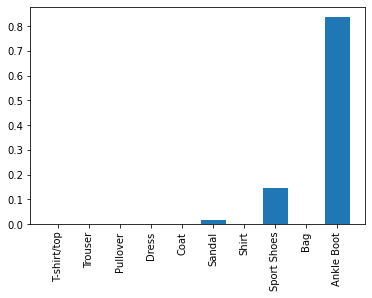

In [20]:
# take the exponent of logps to remove the log
ps = torch.exp(logps)
# convert the score into a numpy value
nps = ps.numpy()[0]

#labels of dataset
FMNIST_labels = ['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

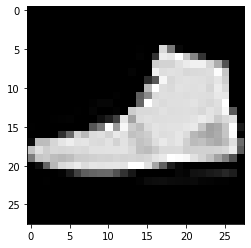

In [25]:
# use normal values (std and mean) for each of the coulour channels across the network
# de-norm does the reverse when we want the actual values
def denormalize(tensor):
    tensor = tensor*0.5 + 0.5
    return tensor

img = img.view(28, -1)
img = denormalize(img)
plt.imshow(img, cmap='gray')